In [1]:

import numpy as np
import matplotlib.pyplot as plt
import joblib
import control as ctr


## Change trigger ID in later function
def upload_file(data_folder, filename):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    fh1= np.array(fh.reshape(-1,4))
    print(fh1[:8,:])
    fh2 = np.array(np.fliplr(fh1))
    fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)

    addr = np.array(np.fliplr(fh3[:,0:6]))
    timestamp = np.array(np.fliplr(fh3[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')-32
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    
    return(np.unique(val_addr, return_counts=True)[1])


def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    a=val_timestamps.shape[0]
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26

    return(val_time)
def histogram_creation(val_addr,val_time,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    a=val_time.shape[0]
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:
            if val_addr[i]<25 and val_addr[i+b]<25:
                hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
                hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    ok
    """

    a = len(val_addr)
    pixels = np.zeros((y_points,x_points))
    lines = np.where(val_addr==234)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==233)[0],[lines[i+1]-lines[i]]))
        print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                    delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    dwell_time = int(dwell_time * 1e5)
    bin_time = int(bin_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((int(np.ceil(dwell_time/bin_time)),x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            delta= 0
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,j])+delta]- val_timestamps[int(pixels[i,j])])/bin_time))
                        counts[bin_number,i,j,val_addr[int(pixels[i,j])+delta]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,y-1-j])+delta]- val_timestamps[int(pixels[i,y-1-j])])/bin_time))
                        counts[bin_number,i,y-1-j,val_addr[int(pixels[i,y-1-j])+delta]] += 1
                    delta += 1
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time,x,y):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)

def counts_binned(val_addr,val_timestamps,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    bin_time = int(bin_time * 1e5)
    max_time = max(val_timestamps)
    counts = np.zeros((int(np.ceil(max_time/bin_time)),23))

    for i  in range(len(val_addr)):
        if val_addr[i]<25:
            bin_number = int(np.floor((val_timestamps[i])/bin_time))
            counts[bin_number,val_addr[i]] += 1
           
    return(counts)


(correction,correction_extra)= joblib.load('correction_parameters_laser.pkl')

[[255 255 255 239]
 [  8  74   0 128]
 [181 182   0 128]
 [134 216   0 128]
 [ 82 234   0 128]
 [ 52 154   1 128]
 [125 238   1 128]
 [228  37   2 128]]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in uint_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in uint_scalars


0


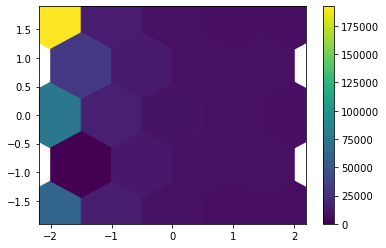

In [2]:
# Processing single pixel data for G2 measurement
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.07/",filename = "bead_calibration_06_07_2020_v1")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
#correction,correction_extra=calc_correction(mode='upload', channels=23,hist=[],counts_detec=[],filename='correction_parameters_laser.pkl')
hist =  histogram_creation(val_addr,val_timestamps,time_range =100)
#hist_corrected = histogram_correction(hist,correction,correction_extra,counts_detec,100)
pos = histogram_plot(val_addr)

[      0   60104  123144  199557  302234  419681  543061  678430  777993
  855852  953933 1053382 1157322 1265383 1347312 1405555 1462576 1525979
 1598266 1675948 1752863 1823941]
[      0   70842  147481  250912  342770  406578  463809  537069  633437
  738854  853450  982190 1086196 1160835 1257917 1358940 1439507 1513519
 1604694 1708384 1804284 1892176]
[      0   86226  173254  259969  321564  365985  413916  470850  528146
  593917  691299  795204  881996  954981 1025523 1106040 1184689 1275890
 1404090 1528161 1619468 1715893]
[      0  126772  280928  427935  524220  627548  757904  856841  917680
  984238 1060074 1131399 1200484 1271400 1325366 1363840 1406653 1463569
 1532802 1596973 1647642 1696131]
[      0   50852  120020  208220  286277  335921  382371  445060  527958
  608591  668117  725008  784480  845169  924387 1046181 1170608 1249444
 1342074 1499515 1658794 1760308]
[      0  102906  233813  339004  413462  492936  603647  727218  826042
  891782  948703 1007398 10

In [ ]:
plt.plot(val_time)

In [4]:
#intensity scan analysis with time binning
#final data- (counts) intensity value of each pixel in every scan point binned 
# format :(x,y,detector)
# dwell and bin times in ms
nanoSPAD_X= 20
nanoSPAD_Y= 20
dwell_time = 250
bin_time = 1
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.07/",filename = "5mhz_15_07_v3")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)

#Counts variables(with/without binning)
#counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
counts_bin = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

[[255 255 255 239]
 [249  32   0 152]
 [225  52   0 152]
 [117  65   0 128]
 [ 49 104   0 128]
 [ 82 129   0 204]
 [114 189   0 148]
 [229 198   0 128]]
[     0  28542  57925  87942 118717 150287 183019 217220 252844 291029
 329912 371108 414595 461338 511891 564556 618603 676115 736728 801137
 869906 942421]
[     0  77348 149040 213279 272541 328265 381094 430532 477380 522414
 565119 606476 646572 685058 721046 755075 787318 817718 846865 874620
 901265 927002]
[     0  27228  54954  83737 113887 145998 180562 217333 256636 298788
 343116 388943 436966 486180 536540 588024 640160 695311 752242 811341
 875784 944803]
[      0   73534  142298  207645  270800  332501  393999  455149  515039
  573139  629410  684063  736800  786089  832343  874595  913933  949861
  982859 1013072 1042035 1069433]
[      0   30764   62793   97364  134431  175209  220748  270135  324557
  383455  445813  511583  579756  648007  717521  787181  856837  925409
  993932 1061808 1130620 1200316]
[      0   79

In [6]:
counts_detec

array([2401410, 2077869, 2700883, 2882662, 2753889, 2129172, 2809013,
       3578924, 3728059, 1803038, 2869454, 3855911, 4327807, 4057278,
       3339362, 4157460, 4321169, 1570881, 2389780, 3205185, 3705796,
       3624942,     400,      21,       3], dtype=int64)

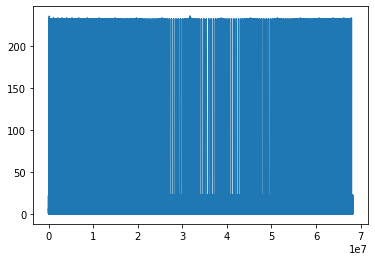

In [7]:
plt.plot(val_addr)


In [11]:
np.max(counts_bin)
print(2**7)

128


In [22]:
val_addr.max()

236

In [12]:
np.save("5mhz_15_07_v3",counts_bin.astype('int16'))

In [41]:
#min dead time calculation(VQ=0.85V-approved by Michel to increase VQ until dead time is equal 50 ns)
#recommended in manual VQ= 0.75(left power supply ch 3)
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist[i,i,:]>0)[0])),'ns')

0 60 ns
1 70 ns
2 90 ns
3 70 ns
4 70 ns
5 90 ns
6 50 ns
7 110 ns
8 60 ns
9 70 ns
10 60 ns
11 80 ns
12 70 ns
13 80 ns


ValueError: min() arg is an empty sequence

In [40]:
# (G2 correction coefficient for laser)
correction = np. zeros((23,23))
correction_extra  = np. zeros((18,3))
for i in range(23):
    for j in range(23):
        if i!=j:
            correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
        if i+5==j:

            correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
joblib.dump((correction,correction_extra),'correction_parameters_laser.pkl')       

['correction_parameters_laser.pkl']

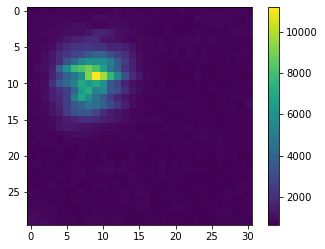

In [15]:


plt.imshow(counts.sum(axis=2))
plt.colorbar()
plt.show()

0


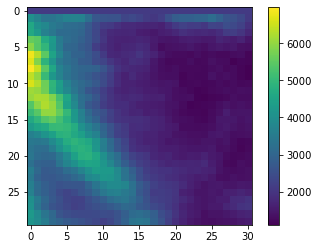

1


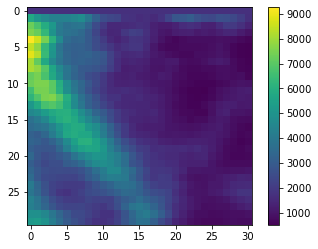

2


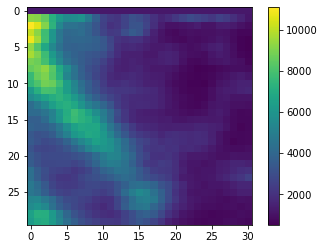

3


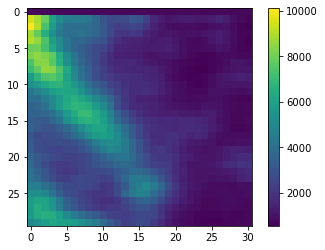

4


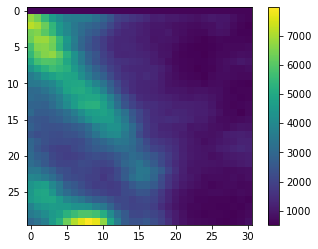

5


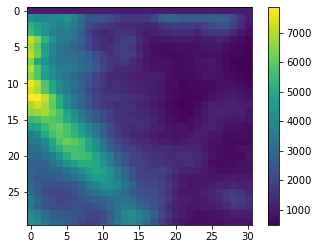

6


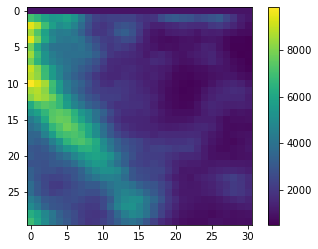

7


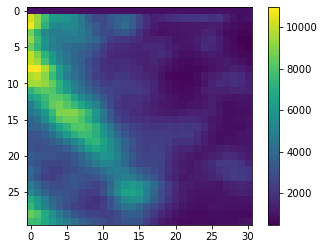

8


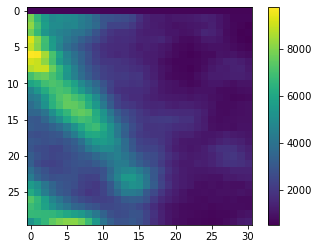

9


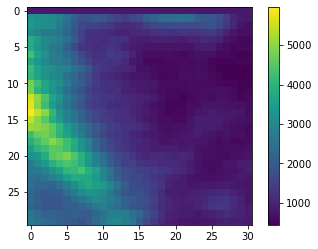

10


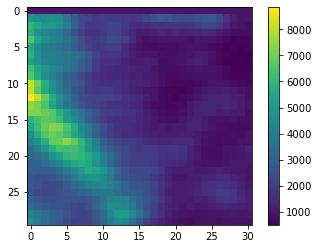

11


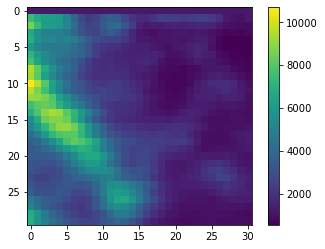

12


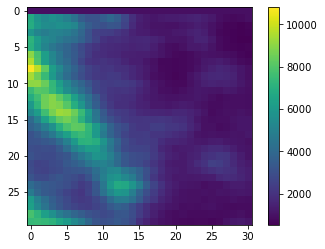

13


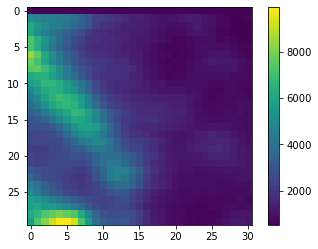

14


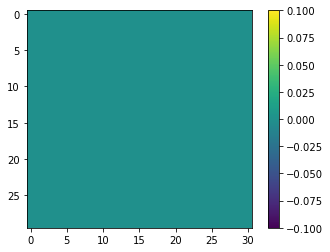

15


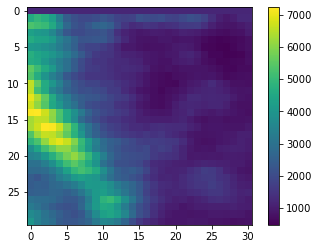

16


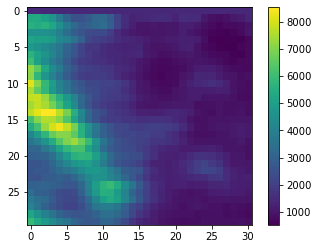

17


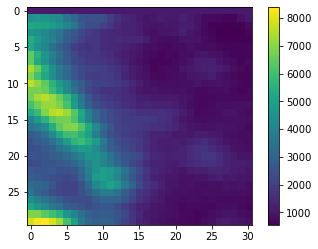

18


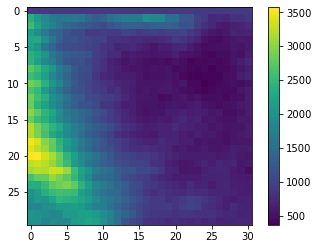

19


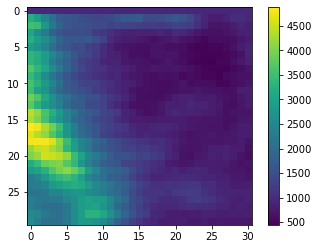

20


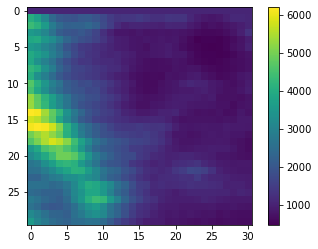

21


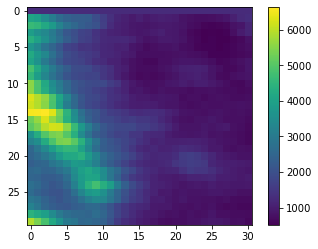

22


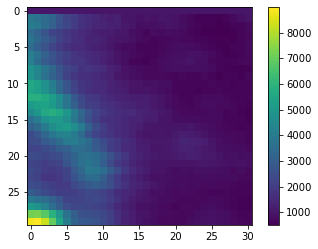

In [7]:
for i in range(23):
    print(i)
    plt.imshow(counts[:,:,i])
    plt.colorbar()
    plt.show()

In [34]:
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.07/",filename = "alexa_no_scan_8_7_2020_nr2")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)

[[255 255 255 239]
 [224 195   0 128]
 [128 214   0 128]
 [ 67   5   1 128]
 [227  72   1 128]
 [167 127   1 128]
 [248 141   1 128]
 [150 247   1 128]]


In [14]:
len(val_addr)
print(67108862/37.549)

1787234.3338038297


In [58]:
hist = histogram_creation(val_addr,val_time,1)

In [68]:
c = counts_binned(val_addr,val_time,10)

In [66]:
c.shape

(205, 23)

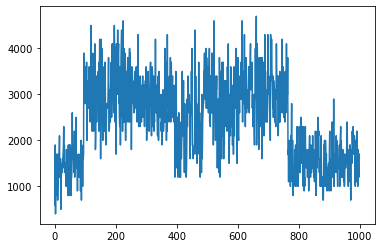

In [73]:
plt.plot((np.sum(c[0:750000,1:],axis=1)*100)[0:1000])

In [11]:
counts_bin.shape

(300, 20, 21, 23)

In [75]:
m=700
A=np.zeros(m)

c1=c[0:750,1:]-c[0:750,1:].mean(axis=0)
N=c1.shape[0]
for i in range(m):
    A[i]=(c1[i:N]*c1[:N-i]).mean(axis=0).sum()

In [39]:
c1[i:N].shape

(0, 22)

In [40]:
i

2050

In [191]:
A.shape

(10000,)

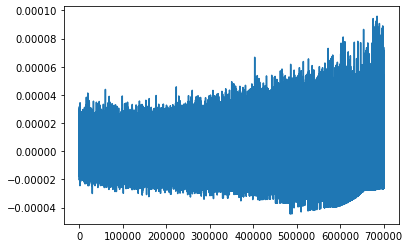

In [43]:
plt.plot(A[1:])

In [44]:
np.save("noise_vector_16_07",A.astype('float'))

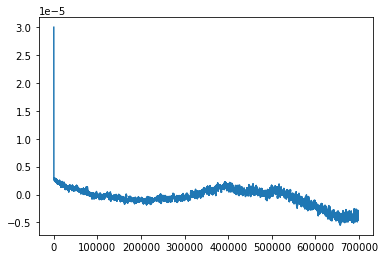

In [55]:
B = np.zeros(698000)
for a in range(698000):
    B[a] = np.mean(A[a:a+1000])
plt.plot(B)

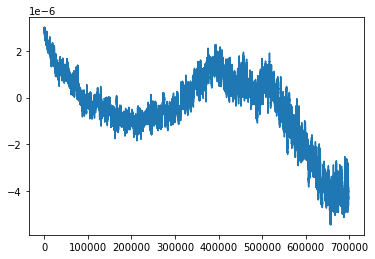

In [57]:
plt.plot(B[1:])

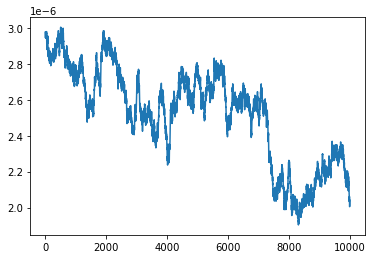

In [56]:
plt.plot(B[1:10000])

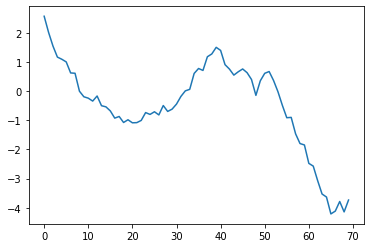

In [224]:
plt.plot(AA)

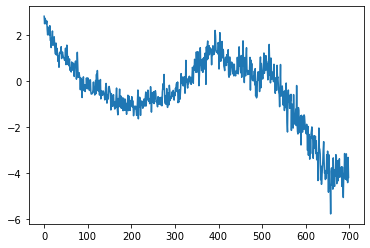

In [77]:
plt.plot(A[1:])

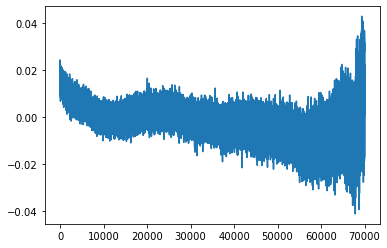

In [71]:
plt.plot(A[1:])

In [ ]:
700*10

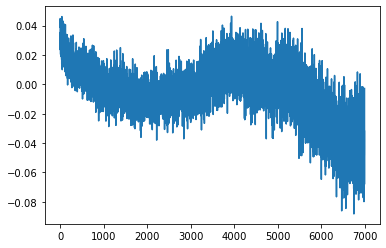

In [215]:
plt.plot(A[1:])

In [216]:
A.shape

(7000,)

In [219]:
A.shape[0]/100

70.0

In [223]:
AA=np.zeros(int(A.shape[0]/100))
for i in range(int(A.shape[0]/100)): 
    AA[i]=A[1+100*i:100*i+101].sum()

In [58]:
bbbb=np.zeros((1,aaaa.shape[0],aaaa.shape[1],aaaa.shape[2],aaaa.shape[3]+2))

In [59]:
bbbb[0,:,:,:,:-2]=aaaa

In [60]:
def rebin(scans, u=0):
    scans2=np.array([np.sum(scans[:,int(u*i):int(u*i+u),:,:,:],axis=1) for i in range(int(scans[0,:,:,:,0].shape[0]/u))])
    return np.transpose(scans2, (1,0,2,3,4))


In [50]:
aaaa=np.load('Adrian_v3_19_6_1uW_5Mhz.npy')

In [61]:
scans=rebin(bbbb,2)

In [62]:
np.save('scans_2',scans.astype('int16'))